## Handcraft network

In [115]:
from detect_train import *
from PIL import Image
import torchvision.transforms as transforms
import torch

#datadir = "/home/scuk/RS/thinker/data/detect/v5_sok-32052928-0"
datadir = "/home/scuk/RS/thinker/data/detect/v5c_sp0-49956736-0"
dataset = CustomDataset(datadir=datadir, transform=None, chunk_n=1, data_n=10000)
sampler = ChunkSampler(dataset)
dataloader = DataLoader(dataset, batch_size=2048, sampler=ChunkSampler(dataset))

device = torch.device("cuda")

# load setting
yaml_file_path = os.path.join(datadir, 'config_detect.yaml')
with open(yaml_file_path, 'r') as file:
    flags_data = yaml.safe_load(file)
flags_data = argparse.Namespace(**flags_data)
num_actions = flags_data.num_actions
rec_t = flags_data.rec_t

# Path to your BMP file
image_path = '/home/scuk/RS/thinker/data/player_on_dan_small.bmp'
# Load the image
image = Image.open(image_path)
# Convert the image to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to Tensor, scales to [0, 1] range
])
search_image = transform(image).to(device)



In [159]:
def find_max_similarity_single_function(x, search_image):
    B, C, H, W = x.shape  # Batch size, Channels, Height, Width
    block_size = 8
    num_blocks_h = H // block_size  # Number of horizontal blocks
    num_blocks_w = W // block_size  # Number of vertical blocks

    x_reshaped = x.view(B, C, num_blocks_h, block_size, num_blocks_w, block_size)
    # Permute to group blocks together while keeping the batch and channel dimensions intact
    x_permuted = x_reshaped.permute(0, 2, 4, 1, 3, 5)
    # Flatten the block grid dimensions to list all blocks sequentially
    x_blocks = x_permuted.reshape(B, num_blocks_h * num_blocks_w, C * block_size * block_size)
    # Normalize the blocks and the search_image
    x_blocks_norm = F.normalize(x_blocks+1e-6, p=2, dim=-1)  # Normalize over channel dimension
    search_image_norm = F.normalize(torch.flatten(search_image), p=2, dim=-1)

    similarity = torch.sum(x_blocks_norm * search_image_norm, dim=-1)

    # Find the maximum similarity for each image in the batch
    max_similarity, _ = similarity.view(B, -1).max(dim=1)
    return max_similarity

def mask_top_rank(x, rank):
    # args: x (tensor) of shape (B, N); rank (int)
    # return a mask that equals 1 if the element of each row is the rank largest element
    B, N = x.shape
    sorted_values, _ = x.sort(dim=1, descending=True)
    ties = (sorted_values[:, 1:] - sorted_values[:, :-1]) != 0
    cum_ties = torch.cumsum(ties, dim=-1)
    cum_ties = torch.concat([torch.zeros(B, 1, device=x.device), cum_ties], dim=-1)
    idx = torch.argmax((cum_ties == rank).float(), dim=1)
    not_found = torch.all(~(cum_ties == rank), dim=-1)
    rank_values = sorted_values[torch.arange(B, device=x.device), idx]
    mask = x == rank_values.unsqueeze(-1)
    mask[not_found] = False
    return mask

#B = 2048
#env_state = torch.stack([dataset[idx][0]["env_state"] for idx in range(B)]).to(device)
#tree_rep = torch.stack([dataset[idx][0]["tree_rep"] for idx in range(B)]).to(device)
#target_y = torch.stack([dataset[idx][1] for idx in range(B)]).to(device)

eval_results = {}
search_rank = 0

with torch.set_grad_enabled(False):

    for xs, target_y in dataloader:

        env_state = xs["env_state"].to(device)
        tree_rep = xs["tree_rep"].to(device)
        target_y = target_y.to(device)

        B, rec_t = env_state.shape[:2]

        # for sokoban
        # max_sim = find_max_similarity_single_function(torch.flatten(env_state, 0, 1), search_image)
        # max_sim = max_sim.view(B, rec_t)

        # for point goal
        mask = torch.zeros(240, dtype=torch.bool)
        for i in range(3, 4):
            mask[60*i+22:60*i+22+16] = 1
            #mask[60*i+41:60*i+41+16] = 1
        #max_sim = torch.sum((env_state[:, :, mask] > 0.95).float(), dim=-1) >= 0.5
        max_sim = torch.sum((env_state[:, :, mask] > 0.9).float(), dim=-1) >= 1

        # compute last rollout return

        idx_reset = num_actions * 4 + 6
        idx_rr = idx_reset + flags_data.rec_t + 1
        reset = tree_rep[:, :, idx_reset].bool()
        rollout_return = tree_rep[:, :, idx_rr]

        last_rollout_return = rollout_return.clone()
        r = last_rollout_return[:, -1].clone()
        for n in range(flags_data.rec_t-1, -1, -1):
            r[reset[:, n]] = last_rollout_return[reset[:, n], n]
            last_rollout_return[:, n] = r  

        search_mask = torch.zeros(B, rec_t, dtype=torch.bool, device=device)
        search_mask[:, 0] = 1

        for m in range(search_rank+1):
            search_mask = search_mask | mask_top_rank(last_rollout_return, m)

        max_sim[~search_mask] = 0
        max_sim = torch.max(max_sim, dim=-1)[0]
        pred_y = max_sim > 0.95
        
        result = evaluate_detect(target_y, pred_y)
        for k, v in result.items():
            if k not in eval_results: 
                eval_results[k] = [v]
            else:
                eval_results[k].append(v)


for k in eval_results:
    eval_results[k] = np.mean(np.array(eval_results[k]))

print(eval_results)    


{'acc': 0.870221757888794, 'rec': 0.6387614607810974, 'prec': 0.6094553828239441, 'f1': 0.6229297759159571, 'neg_p': 0.8314314842224121}


In [18]:
max_sim = find_max_similarity_single_function(torch.flatten(env_state, 0, 1), search_image)
env_state_ = env_state.flatten(0, 1)

midx = torch.nonzero(max_sim > 0.95).squeeze(-1)
idx = torch.randperm(midx.shape[0])
midx = midx[idx][:20]
d_env_state = env_state_[midx]

midx = torch.nonzero(max_sim < 0.95).squeeze(-1)
idx = torch.randperm(midx.shape[0])
midx = midx[idx][:20]
s_env_state = env_state_[midx]

In [37]:
from torchvision.utils import save_image

border_size = 0  # Size of the black border
scale_factor = 6

# Calculate the new size including the border
if border_size > 0:
    new_height = d_env_state.size(2) + 2*border_size
    new_width = d_env_state.size(3) + 2*border_size

    d_env_state_ = torch.zeros((d_env_state.size(0), 3, new_height, new_width), device=d_env_state.device)
    d_env_state_[:, :, border_size:-border_size, border_size:-border_size] = d_env_state

    s_env_state_ = torch.zeros((s_env_state.size(0), 3, new_height, new_width), device=s_env_state.device)
    s_env_state_[:, :, border_size:-border_size, border_size:-border_size] = s_env_state
else:
    d_env_state_ = d_env_state
    s_env_state_ = s_env_state

d_env_state_ = F.interpolate(d_env_state_, scale_factor=scale_factor, mode='nearest')
s_env_state_ = F.interpolate(s_env_state_, scale_factor=scale_factor, mode='nearest')

for i in range(d_env_state.shape[0]):
    image_filename = f"../data/sample/d_{i}.png"
    img = d_env_state_[i]
    save_image(img, image_filename)
for i in range(s_env_state.shape[0]):
    image_filename = f"../data/sample/s_{i}.png"
    img = s_env_state_[i]
    save_image(img, image_filename)    


## DRC hidden state visualization

In [1]:
# DRC hidden state visualization

import os
import numpy as np
import yaml
import argparse
import re
import gc

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler
from detect_train import *

datadir = "../data/detect/v18_drc_2-1/"
dataset = CustomDataset(datadir=datadir, transform=None, data_n=3200, prefix="test", chunk_n=1)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

for n in range(20):
    data = dataset[n]
    env_state = data[0]["env_state"][0]
    hidden_state = data[0]["hidden_state"][0]

    # Calculate the correct number of rows for all channels
    num_channels_per_part = 64  # This should be 64 given 192 total channels

    # Create a figure with a custom layout, making the first row larger
    fig = plt.figure(figsize=(16, 3 * num_channels_per_part + 4))  # Adjusted figure height based on number of channels
    gs = gridspec.GridSpec(nrows=num_channels_per_part * 2 + 1, ncols=12, height_ratios=[2] + [1] * 2 * num_channels_per_part)

    # Plotting env_state in the first row, spanning all columns
    env_ax = plt.subplot(gs[0, :])
    env_ax.imshow(torch.clamp(env_state, 0., 1.).float().permute(1, 2, 0).numpy())
    env_ax.set_title('Environment State')
    env_ax.axis('off')

    # Plotting hidden state images
    hidden_state_parts = torch.chunk(hidden_state, 3, dim=1)
    for part_idx, part in enumerate(hidden_state_parts):
        for channel_idx in range(num_channels_per_part):  # Adjusted to iterate over all channels
            h_min = torch.min(part[:, channel_idx]).item()
            h_max = torch.max(part[:, channel_idx]).item()
            for t in range(4):
                row = channel_idx * 2 + 1  # Start from the second row of the grid
                col = t + part_idx * 4
                ax = plt.subplot(gs[row, col])
                img_to_plot = part[t, channel_idx].detach().numpy()
                ax.imshow(img_to_plot, cmap='gray', vmin=h_min, vmax=h_max)                
                ax.axis('off')
                if channel_idx == 0:  # Labeling the first row of hidden state images
                    ax.set_title(f'Layer {part_idx + 1}: t={t}')
                if col == 0 and channel_idx > 0:
                    ax.set_title(f"Channel {channel_idx + 1}")
                if t > 0:
                    img_to_plot = (part[t, channel_idx] - part[t - 1, channel_idx]).detach().numpy()
                    ax = plt.subplot(gs[row + 1, col])
                    ax.imshow(img_to_plot, cmap='gray')
                    ax.axis('off')
                    

    # plt.show()
    plt.savefig(f'drc_{n}.png', bbox_inches='tight')


## Tests

In [1]:
import os
import numpy as np
import yaml
import argparse
import re
import gc

import torch
from detect_train import *

In [2]:
xpids = ["v18_drc_2-1", "v18_drc_2mds_2-1", "v18_drc_4mds-1", "v18_drc_8mds-1"]
for xpid in xpids:
    xs, ys = torch.load(os.path.abspath(f"../data/detect/{xpid}/test.pt"))
    im_actions = torch.transpose(xs["pri_action"], 1, 2)
    im_action = im_actions[..., 1:]
    real_action = ys['last_real_actions']
    acc = torch.mean(torch.all(im_action == real_action, dim=-1).float()).item()
    print(xpid, acc)

v18_drc_2-1 0.7322656512260437
v18_drc_2mds_2-1 0.7182812690734863
v18_drc_4mds-1 0.6775781512260437
v18_drc_8mds-1 0.5087500214576721


In [62]:
xpid = "v5_sok-2"
#xpid = "v18_thinker-1"
datadir = os.path.abspath(f"../data/detect/{xpid}")
xs, ys = torch.load(os.path.join(datadir, 'test.pt'))

# load setting
yaml_file_path = os.path.join(datadir, 'config_detect.yaml')
with open(yaml_file_path, 'r') as file:
    flags_data = yaml.safe_load(file)
flags_data = argparse.Namespace(**flags_data)
num_actions = flags_data.num_actions
rec_t = flags_data.rec_t

In [66]:
def mask_top_rank(x, rank):
    # args: x (tensor) of shape (B, N); rank (int)
    # return a mask that equals 1 if the element of each row is the rank largest element
    B, N = x.shape
    sorted_values, _ = x.sort(dim=1, descending=True)
    ties = (sorted_values[:, 1:] - sorted_values[:, :-1]) != 0
    cum_ties = torch.cumsum(ties, dim=-1)
    cum_ties = torch.concat([torch.zeros(B, 1, device=x.device), cum_ties], dim=-1)
    idx = torch.argmax((cum_ties == rank).float(), dim=1)
    not_found = torch.all(~(cum_ties == rank), dim=-1)
    rank_values = sorted_values[torch.arange(B, device=x.device), idx]
    mask = x == rank_values.unsqueeze(-1)
    mask[not_found] = False
    return mask

num_actions = flags_data.num_actions
T, rec_t, B = xs["env_state"].shape[:3]
env_state = xs["env_state"].transpose(1,2)
tree_rep = xs["tree_rep"].transpose(1,2)
pri_action = xs["pri_action"].transpose(1,2)
real_action = ys['last_real_actions'].reshape((T*B,) + ys['last_real_actions'].shape[2:])

env_state = env_state.reshape( (T*B, rec_t) + env_state.shape[3:])
tree_rep = tree_rep.reshape( (T*B, rec_t) + tree_rep.shape[3:])
pri_action = pri_action.reshape( (T*B, rec_t) + pri_action.shape[3:])

if "v5" not in xpid:
    idx_reset = num_actions * 10 + 9
    idx_rr = num_actions * 5 + 4
else:
    idx_reset = num_actions * 4 + 6
    idx_rr = idx_reset + flags_data.rec_t + 1
reset = tree_rep[:, :, idx_reset].bool()
#assert torch.all(reset == reset[[0]])

rollout_return = tree_rep[:, :, idx_rr]

last_rollout_return = rollout_return.clone()
r = last_rollout_return[:, -1].clone()
for n in range(flags_data.rec_t-1, -1, -1):
    #r = torch.maximum(r, last_rollout_return[:, n])
    r[reset[:, n]] = last_rollout_return[reset[:, n], n]
    last_rollout_return[:, n] = r  

#top_idx = torch.argmax(last_rollout_return[:, ::5][:, 1:], dim=-1)    
top_idx = torch.zeros(T*B, dtype=torch.long)
mask = torch.zeros(T*B, rec_t, dtype=torch.bool)
for i in range(5): mask[torch.arange(T*B), top_idx*5+i] = 1
im_action = pri_action[mask].view(T*B, 5)
acc = torch.mean(torch.all(im_action == real_action, dim=-1).float()).item()
print(acc)

0.490234375


In [51]:
last_rollout_return[0]

tensor([2.5067, 2.3442, 2.3442, 2.3442, 2.3442, 2.3442, 2.1739, 2.1739, 2.1739,
        2.1739, 2.1739, 2.3442, 2.3442, 2.3442, 2.3442, 2.3442, 2.2092, 2.2092,
        2.2092, 2.2092])

In [22]:
last_rollout_return[0]

tensor([7.5124, 7.5124, 7.5124, 7.5124, 7.5124, 7.5124, 3.7723, 3.7723, 3.7723,
        3.7723, 3.7723, 3.7720, 3.7720, 3.7720, 3.7720, 3.7720, 4.7112, 4.7112,
        4.7112, 4.7112])

In [14]:
top_idx = torch.argmax(last_rollout_return[:, ::5][:, 1:], dim=-1)    
mask = torch.zeros(T*B, rec_t, dtype=torch.bool)
for i in range(5): mask[torch.arange(T*B), top_idx*5+i] = 1
im_action = pri_action[mask].view(T*B, 5)
acc = torch.mean(torch.all(im_action == real_action, dim=-1).float()).item()
print(acc)

0.47914063930511475


In [11]:
tree_rep[:, :, idx_reset][2]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        0., 0.])

In [67]:
for i in range(8):
    print(i)
    print("real_action", real_action[i])
    print("im_action", im_action[i])
    print("pri_action", pri_action[i][:15].view(3, 5))
    print("rollout_return", rollout_return[i][1:15+1].view(3, 5))
    print("last_rollout_return", last_rollout_return[i][1:15+1].view(3, 5))
    print("top_idx", top_idx[i])

0
real_action tensor([1, 3, 3, 2, 2])
im_action tensor([1, 3, 3, 2, 2])
pri_action tensor([[1, 3, 3, 2, 2],
        [4, 2, 4, 4, 4],
        [4, 2, 4, 4, 4]])
rollout_return tensor([[5.9111, 5.5473, 6.4628, 6.9341, 7.5124],
        [5.5600, 5.1581, 5.1594, 4.7098, 3.7723],
        [5.5606, 5.1577, 5.1590, 4.7104, 3.7720]])
last_rollout_return tensor([[7.5124, 7.5124, 7.5124, 7.5124, 7.5124],
        [3.7723, 3.7723, 3.7723, 3.7723, 3.7723],
        [3.7720, 3.7720, 3.7720, 3.7720, 3.7720]])
top_idx tensor(0)
1
real_action tensor([2, 3, 3, 1, 4])
im_action tensor([2, 3, 3, 1, 4])
pri_action tensor([[2, 3, 3, 1, 4],
        [4, 1, 1, 1, 1],
        [2, 3, 3, 1, 4]])
rollout_return tensor([[1.9525, 1.7005, 1.6145, 1.9535, 2.0725],
        [1.7429, 1.7068, 1.8453, 1.8631, 1.7121],
        [1.9526, 1.7004, 1.6146, 1.9534, 2.0725]])
last_rollout_return tensor([[2.0725, 2.0725, 2.0725, 2.0725, 2.0725],
        [1.7121, 1.7121, 1.7121, 1.7121, 1.7121],
        [2.0725, 2.0725, 2.0725, 2.0725, 

In [171]:
real_action[2]

tensor([2, 2, 3, 4, 4])

In [157]:
for i in range(8):
    print(pri_action[i], im_action[i])

tensor([3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3]) tensor([3, 3, 1, 3, 3])
tensor([3, 1, 1, 1, 4, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]) tensor([3, 1, 1, 1, 4])
tensor([3, 2, 3, 4, 1, 2, 3, 2, 3, 4, 1, 3, 2, 3, 2, 3, 2, 3, 4, 3]) tensor([3, 2, 3, 4, 1])
tensor([4, 2, 2, 4, 1, 1, 3, 2, 4, 2, 4, 2, 2, 4, 1, 1, 3, 2, 4, 4]) tensor([4, 2, 2, 4, 1])
tensor([3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3]) tensor([3, 1, 3, 3, 3])
tensor([3, 3, 2, 4, 3, 3, 3, 2, 4, 3, 3, 3, 2, 4, 3, 3, 3, 2, 4, 3]) tensor([3, 3, 2, 4, 3])
tensor([3, 3, 2, 3, 1, 3, 3, 2, 3, 1, 3, 3, 2, 3, 1, 3, 3, 2, 3, 3]) tensor([3, 3, 2, 3, 1])
tensor([4, 1, 3, 1, 4, 2, 4, 1, 3, 1, 4, 4, 2, 2, 3, 1, 4, 2, 4, 4]) tensor([4, 4, 2, 2, 3])


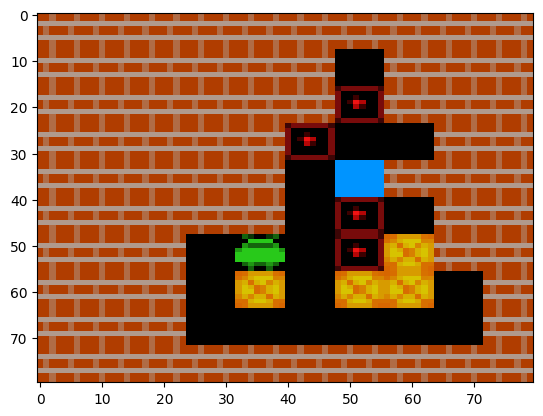

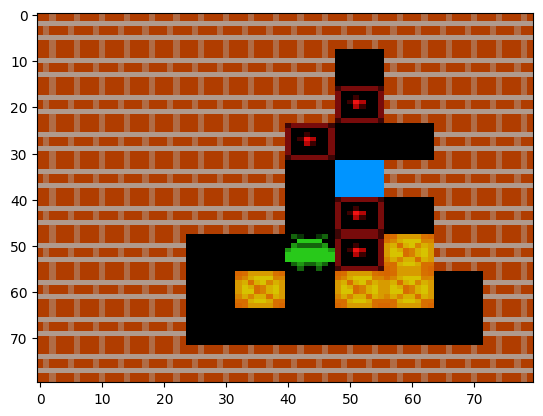

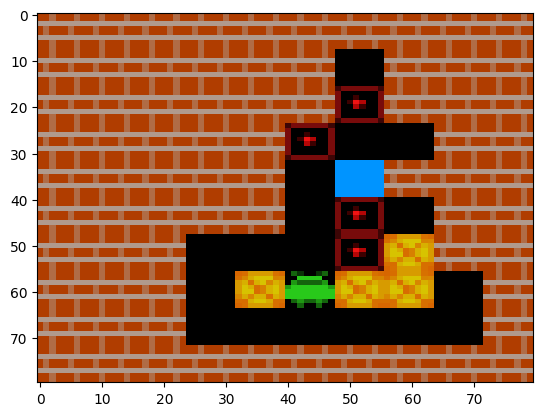

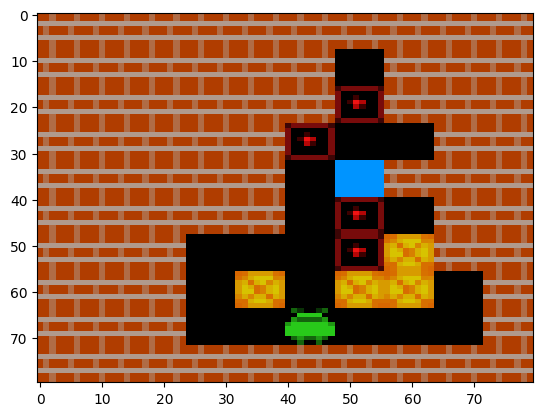

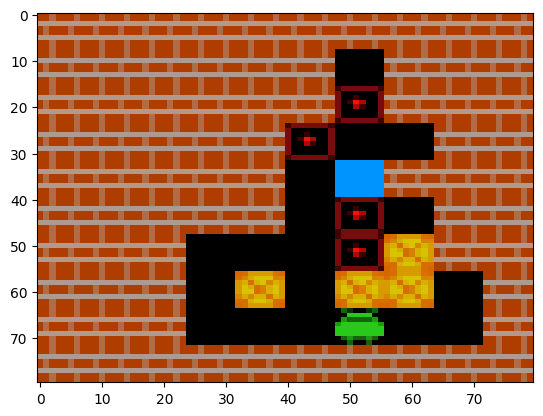

In [180]:
b = 3
for m in range(5):
    util.plot_raw_state(env_state[b+128*m, 0].float())

In [143]:
pri_action[mask].shape

torch.Size([300])

In [145]:
pri_action.shape

torch.Size([12800, 20])

In [144]:
mask.shape

torch.Size([12800, 20])

torch.Size([192000])

In [119]:
xs.keys()

dict_keys(['env_state', 'pri_action', 'cost', 'tree_rep', 'reset_action', 'done', 'step_status'])

tensor([0, 0, 0, 0, 0, 0, 0, 2])

In [95]:
search_mask = torch.zeros(B, rec_t, dtype=torch.bool)
empty = torch.ones(B, dtype=torch.bool)
for m in range(0, 10):
    top_mask = mask_top_rank(last_rollout_return, m)   
    fill = (torch.sum(top_mask, dim=-1) == 5) & empty
    search_mask[fill] = top_mask[fill]
    empty = empty & ~fill
print(torch.mean(empty.float())) 

tensor(0.0855)


In [99]:

top_mask = mask_top_rank(last_rollout_return, 2)   
print(top_mask[0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,  True])


In [71]:
torch.sum(search_mask, dim=-1)

tensor([5, 5, 5,  ..., 0, 5, 5])

In [85]:
torch.mean(empty.float())

tensor(0.0855)

In [93]:
torch.all(reset == reset[[0]])

tensor(True)

In [74]:
last_rollout_return[-3]

tensor([10.2544, 10.3863, 10.3863, 10.3863, 10.3863, 10.0223, 10.0223, 10.0223,
         9.7173,  9.7173,  9.7173,  9.7173,  9.0157,  9.0157,  8.5424,  8.5424,
        10.3460, 10.3460,  9.0157,  9.0157])

In [80]:
reset[3]

tensor([ True, False, False, False, False,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [37]:
tree_rep[:, :, idx_rr]

tensor([[11.2475, 11.1110, 11.1110,  ...,  9.9251,  9.9251,  9.5181],
        [ 3.7751,  3.2984,  2.6073,  ...,  2.6073,  2.9784,  3.2086],
        [ 8.7815,  9.0011,  9.1674,  ...,  7.7627,  7.7627,  7.7627],
        ...,
        [10.2544, 10.3039, 10.3460,  ..., 10.3460,  9.0157,  9.0157],
        [-0.4663, -0.5507, -0.5563,  ..., -0.5258, -0.5158, -0.7828],
        [ 2.7018,  2.7947,  1.7931,  ...,  1.7931,  1.2752,  1.0657]])

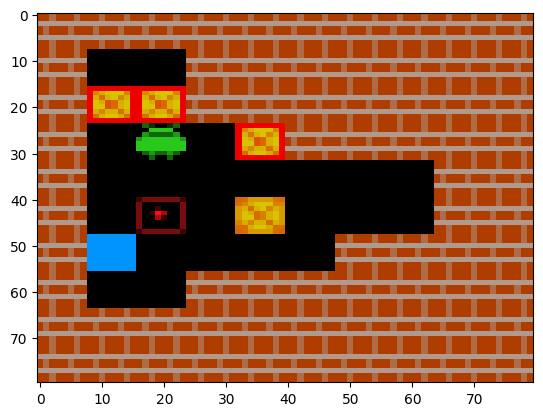

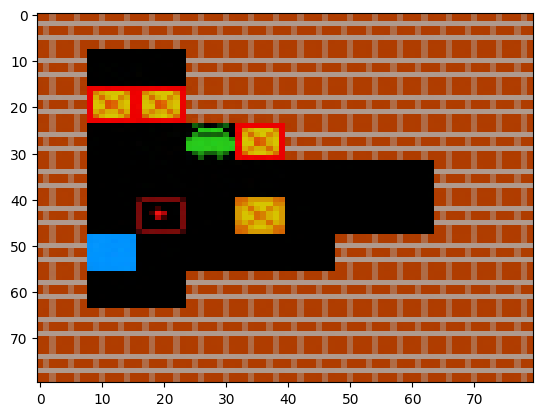

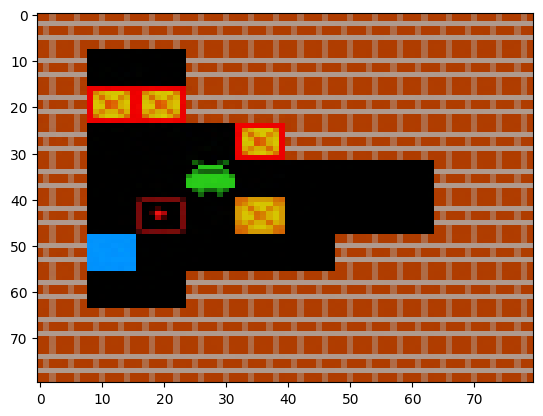

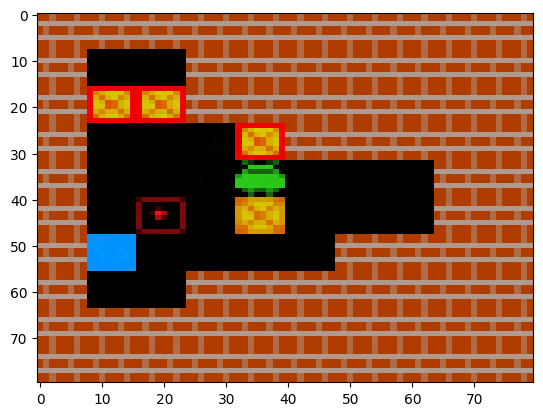

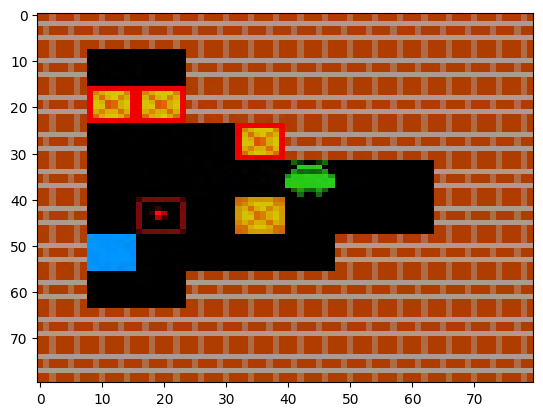

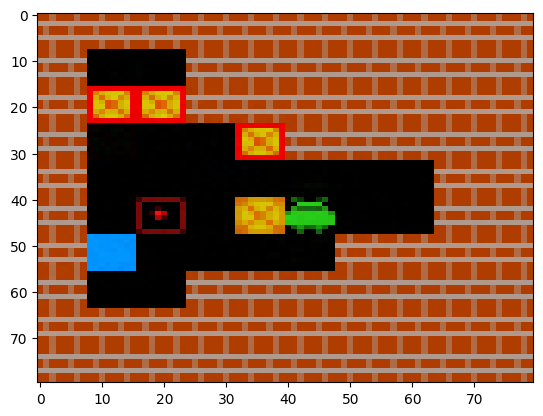

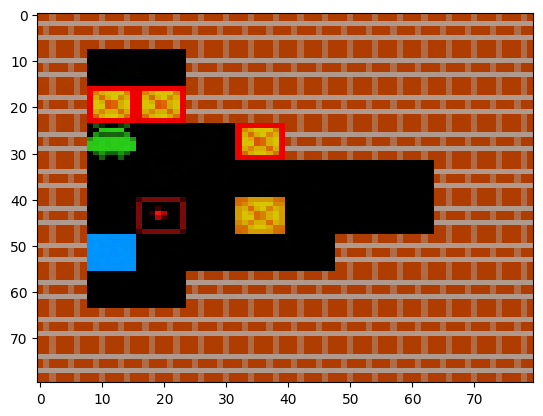

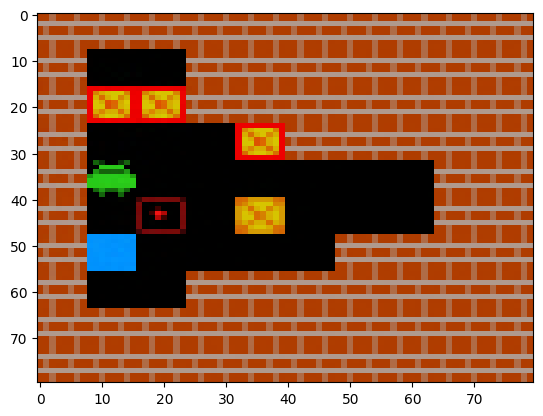

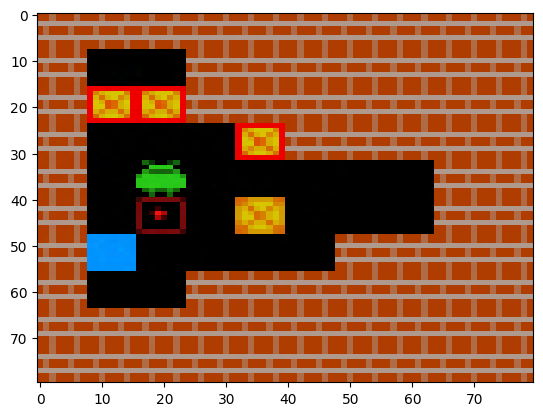

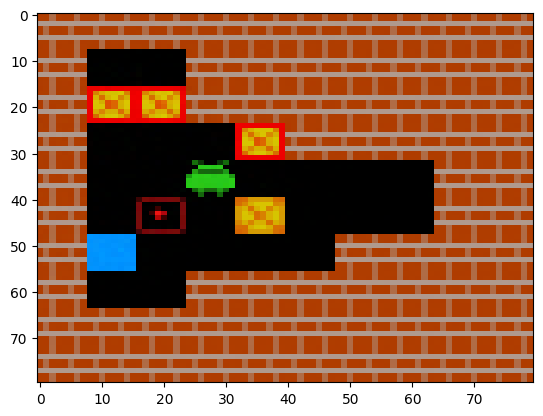

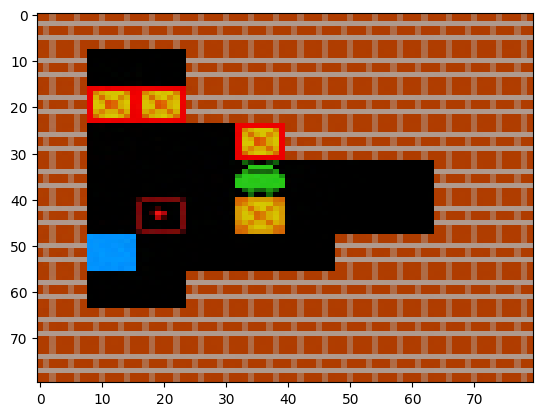

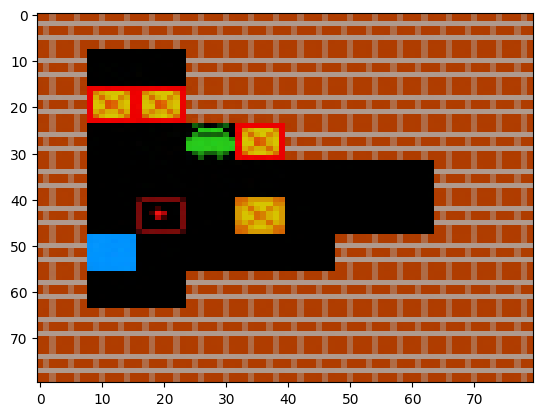

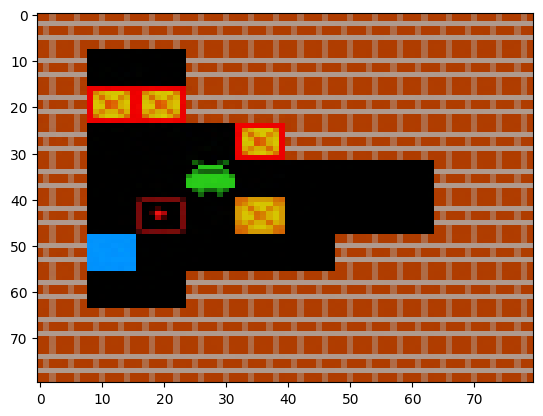

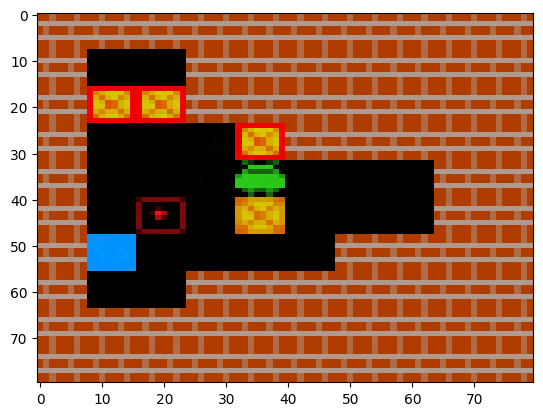

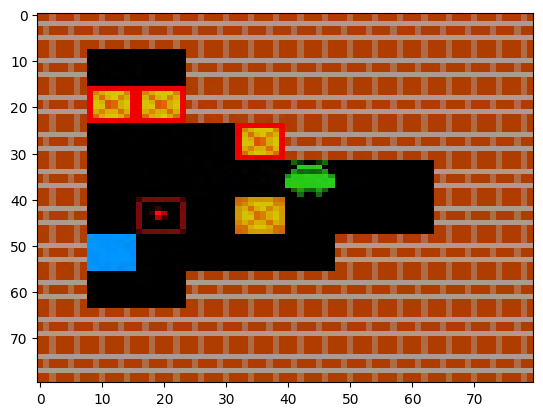

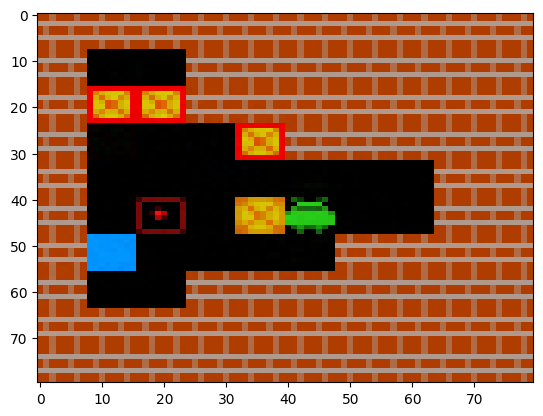

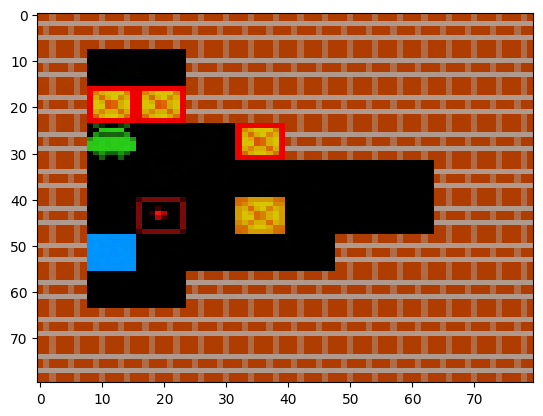

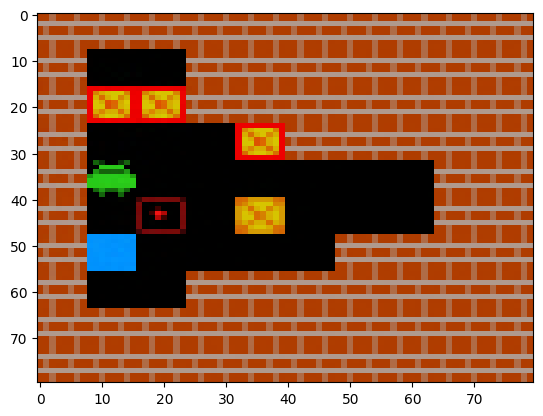

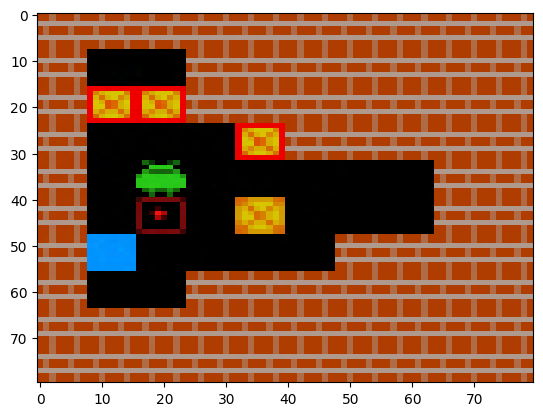

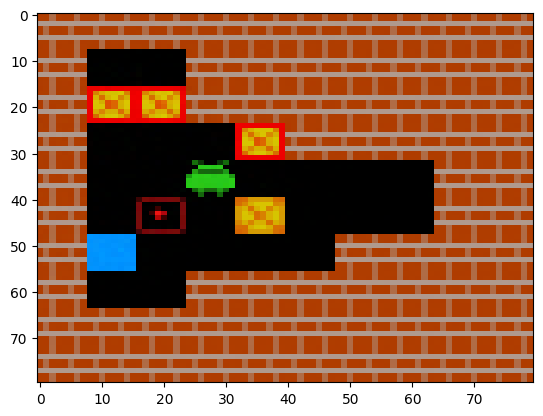

In [5]:
from thinker import util
t, b = 14, 11
env_state = xs["env_state"][t, :, b]
for n in range(len(env_state)):
    util.plot_raw_state(torch.clamp(env_state[n].float(), 0, 1))


## Deprecated

In [14]:
# deprecated

import os 
from torch.utils.data import Dataset, DataLoader
import torch
from thinker import util

datadir = "../data/detect/v5_sok-5993808-1/"
datadir = os.path.abspath(os.path.expanduser(datadir))

class CustomDataset(Dataset):
    def __init__(self, datadir, transform=None):
        self.datadir = datadir
        self.file_list = [f for f in os.listdir(datadir) if f.endswith('.pt')]
        self.transform = transform
        xs, y = torch.load(os.path.join(datadir, self.file_list[0]))        
        self.t = xs['env_state'].shape[0]
        self.b = xs['env_state'].shape[2]
        self.samples_per_file = self.t * self.b

    def __len__(self):
        return len(self.file_list) * self.samples_per_file  # Adjust based on your data

    def __getitem__(self, idx):
        file_idx = idx // self.samples_per_file
        within_file_idx = idx % self.samples_per_file
        t_idx = within_file_idx // self.b
        b_idx = within_file_idx % self.b
        xs, y = torch.load(os.path.join(self.datadir, self.file_list[file_idx]))
        xs.pop('step_status')
        xs.pop('done')
        xs = util.dict_map(xs, lambda x: x[t_idx, :, b_idx])
        y = y[t_idx, b_idx]
        return xs, y

# To load data and train
dataset = CustomDataset(datadir)
# print(dataset[100])
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))


0.2288818359375

In [25]:
from thinker.actor_net import DRCNet, ActorNetBase
from thinker.main import Env
from thinker.self_play import init_env_out, create_env_out
from thinker import util
import torch
import numpy as np

env_n = 16
flags = util.create_setting(args=[], drc=False, save_flags=False, see_h=True, legacy=True, wrapper_type=0, has_action_seq=False)
env = Env(
        name="Sokoban-v0",
        env_n=env_n,
        gpu=True,
        train_model=False,
        parallel=False,
        return_x=True,
        return_h=True,
        flags=flags,
    )

obs_space = env.observation_space
action_space = env.action_space 

device = torch.device("cuda")
# actor_net = DRCNet(obs_space=obs_space, action_space=action_space, flags=flags, tree_rep_meaning=None)
actor_net = ActorNetBase(obs_space=obs_space, action_space=action_space, flags=flags, tree_rep_meaning=None)


Initializing env 0 with device cuda
Model network size: 6637133


Symlinked log directory: /home/stephen/RS/thinker/notebook/logs/latest
Wrote config file to /home/stephen/RS/thinker/notebook/logs/detect-20240205-143653/config_c.yaml


In [26]:
obs_space["tree_reps"]

Box(-inf, inf, (16, 111), float32)

In [ ]:
state_dict = torch.load("../logs/detect/v1a_base_dirloss/ckp_actor.tar")["actor_net_state_dict"]
new_state_dict = {}
for key, value in state_dict.items():
    key = key.replace("actor_encoder", "h_encoder")
    key = key.replace("core", "tree_rep_encoder.rnn")    
    key = key.replace("initial_enc", "tree_rep_encoder.rnn_in_fc")    
    key = key.replace("model_stat_fc", "tree_rep_encoder.rnn_out_fc")    
    new_state_dict[key] = value
actor_net.load_state_dict(new_state_dict)

In [ ]:
for k, v in actor_net.state_dict().items():
    print(k, v.shape)

In [ ]:
for k, v in new_state_dict.items():
    print(k, v.shape)

In [ ]:
checkpoint = torch.load("../logs/detect/v1a_base_dirloss/ckp_actor.tar")["actor_net_state_dict"]
print(checkpoint)

In [ ]:
actor_net = actor_net.to(device)
state = env.reset()
env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
actor_state = actor_net.initial_state(batch_size=env_n, device=device)
rets = []

with torch.set_grad_enabled(False):
    
    while(True):
        actor_out, actor_state = actor_net(env_out=env_out, core_state=actor_state, greedy=False)
        primary_action, reset_action = actor_out.action, None
        state, reward, done, info = env.step(
            primary_action=primary_action, 
            reset_action=reset_action)    
        if torch.any(done):
            rets.extend(info["episode_return"][done].cpu().tolist())            
            print(f"Episode {len(rets)}; Return  {np.mean(np.array(rets))}")
        env_out = create_env_out(primary_action, state, reward, done, info, flags=flags)

In [8]:
cs = ['step', 'real_step', 'actor_net_optimizer_state_dict', 'actor_net_scheduler_state_dict', 'actor_net_state_dict']
for c in cs: checkpoint_[c] = checkpoint[c]
torch.save(checkpoint_, "../logs/detect/v5b_sok_drc/ckp_actor.tar")


In [ ]:
import numpy as np

actor_net = actor_net.to(device)
state = env.reset()
#env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
env_out = init_env_out(state, flags=flags, dim_actions=1, tuple_action=False)  
actor_state = actor_net.initial_state(batch_size=env_n, device=device)
rets = []

with torch.set_grad_enabled(False):
    
    while(True):
        #actor_out, actor_state = actor_net(env_out=env_out, core_state=actor_state, greedy=False)
        #primary_action, reset_action = actor_out.action, None
        primary_action, actor_state = actor_net(obs=env_out, core_state=actor_state, greedy=False)
        primary_action = primary_action[0]
        reset_action = None

        state, reward, done, info = env.step(
            primary_action=primary_action, 
            reset_action=reset_action)    
        if torch.any(done):
            rets.extend(info["episode_return"][done].cpu().tolist())            
            print(f"Episode {len(rets)}; Return  {np.mean(np.array(rets))}")
        env_out = create_env_out(primary_action, state, reward, done, info, flags=flags)

In [ ]:
from thinker.wrapper import DMSuiteEnv
# Example usage
env = DMSuiteEnv(domain_name="acrobot", task_name="swingup", rgb=False)
obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    print(obs, reward, done)
    if done:
        obs = env.reset()
    